FRP

Raw Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the dataset
df = pd.read_csv(r"E:\IPMA\FRP\FRP_2000_2024.csv")

# Ensure lowercase columns for consistency
df.columns = [col.lower() for col in df.columns]

# Convert acquisition date to datetime
df['acq_date'] = pd.to_datetime(df['acq_date'])

# === COUNTING POINTS AND UNIQUE DAYS ===
total_points = len(df)
unique_days = df['acq_date'].nunique()
print(f"Total FRP points in CSV: {total_points}")
print(f"Number of unique days: {unique_days}")

# Start the plot
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-12, 36, 34.5, 66])

# Add map features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='seashell')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot all FRP points with a uniform color
ax.scatter(df['longitude'], df['latitude'], color='maroon', s=0.05, alpha=1, transform=ccrs.PlateCarree())

# Title only, no colorbar
plt.title("All FRP Points (2000–2024)")
plt.tight_layout()
plt.show()
df


In [ ]:
# Classification 4 levels  ≤50 MW (low intensity), 50 to ≤500 MW (moderate to high intensity), 500 ≤ 1000 MW (very high intensity),and >1000 MW (extreme intensity)

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Patch

# Load and prepare data
df = pd.read_csv(r"E:\IPMA\FRP\FRP_2000_2024.csv")
df.columns = [col.lower() for col in df.columns]
df['acq_date'] = pd.to_datetime(df['acq_date'])

# Classification bins and labels
bins = [0, 50, 500, 1000, float('inf')]
labels = ['Low (≤50 MW)', 'Moderate (51–500 MW)', 'Very High (501–1000 MW)', 'Extreme (>1000 MW)']
colors = ['green', 'orange', 'red', 'purple']

# Classify FRP into intensity categories
df['intensity'] = pd.cut(df['frp'], bins=bins, labels=labels, include_lowest=True)

# Begin plot
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-12, 36, 34.5, 66])  # Study area extent

# Add map features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='seashell')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot each category separately and create legend handles as colored squares
legend_handles = []
for label, color in zip(labels, colors):
    cat_df = df[df['intensity'] == label]
    scatter = ax.scatter(cat_df['longitude'], cat_df['latitude'], label=label, color=color,
                         s=0.05, alpha=1, transform=ccrs.PlateCarree())
    legend_handles.append(Patch(color=color, label=label))

# Add legend with custom handles (colored squares)
plt.legend(handles=legend_handles, title='FRP Intensity', loc='upper left')
plt.title("FRP Points Classified by Intensity (2000–2024)")
plt.tight_layout()
plt.show()


In [ ]:
# Classification 3 levels 50 to ≤500 MW (moderate to high intensity), 500 ≤ 1000 MW (very high intensity),and >1000 MW (extreme intensity)

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.patches import Patch

# Load and prepare data
df = pd.read_csv(r"E:\IPMA\FRP\FRP_2000_2024.csv")
df.columns = [col.lower() for col in df.columns]
df['acq_date'] = pd.to_datetime(df['acq_date'])

# Filter out FRP values below 50 MW
df = df[df['frp'] > 50]

# Classification bins and labels (starting from >50)
bins = [50, 500, 1000, float('inf')]
labels = ['Moderate (51–500 MW)', 'Very High (501–1000 MW)', 'Extreme (>1000 MW)']
colors = ['orange', 'red', 'purple']

# Classify FRP into intensity categories
df['intensity'] = pd.cut(df['frp'], bins=bins, labels=labels, include_lowest=False)

# Begin plot
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-12, 36, 34.5, 66])  # Study area extent

# Add map features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, facecolor='seashell')
ax.add_feature(cfeature.OCEAN, facecolor='lightblue')

# Plot each category separately and create legend handles
legend_handles = []
for label, color in zip(labels, colors):
    cat_df = df[df['intensity'] == label]
    ax.scatter(cat_df['longitude'], cat_df['latitude'], label=label, color=color,
               s=0.05, alpha=1, transform=ccrs.PlateCarree())
    legend_handles.append(Patch(color=color, label=label))

# Add legend with custom handles
plt.legend(handles=legend_handles, title='FRP Intensity', loc='upper left')
plt.title("FRP Points Classified by Intensity (2000–2024, >50 MW)")
plt.tight_layout()
plt.show()


FRP csv file to separate csv files by country

In [ ]:
# Get a point dataset for each region and removes >50 MW

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Paths to shapefiles
shapefile_paths = {
    "Spain": r"E:\IPMA\Countries\ESP\gadm41_ESP_0.shp",
    "Portugal": r"E:\IPMA\Countries\PRT\gadm41_PRT_0.shp",
    "Greece": r"E:\IPMA\Countries\GRC\gadm41_GRC_0.shp",
    "Italy": r"E:\IPMA\Countries\ITA\gadm41_ITA_0.shp",
}

# Load FRP CSV data
df = pd.read_csv(r"E:\IPMA\FRP\FRP_2000_2024.csv")
df.columns = [col.lower() for col in df.columns]
df['acq_date'] = pd.to_datetime(df['acq_date'])

# Filter points with frp > 50 MW
df_filtered = df[df['frp'] > 50].copy()

# Create GeoDataFrame from filtered points
geometry = [Point(xy) for xy in zip(df_filtered['longitude'], df_filtered['latitude'])]
gdf_points = gpd.GeoDataFrame(df_filtered, geometry=geometry, crs="EPSG:4326")

# Loop over countries, filter points inside, and save CSV
for country, shp_path in shapefile_paths.items():
    # Load country polygon(s)
    gdf_country = gpd.read_file(shp_path).to_crs("EPSG:4326")

    # Spatial join: points inside country polygon
    points_in_country = gpd.sjoin(gdf_points, gdf_country, predicate='within', how='inner')

    # Drop spatial join helper columns and geometry before saving CSV
    points_in_country = points_in_country.drop(columns=['index_right', 'geometry'])

    # Save filtered points to CSV
    output_path = rf"E:\IPMA\FRP\FRP_2000_2024_{country}.csv"
    points_in_country.to_csv(output_path, index=False)

    print(f"Saved {len(points_in_country)} points for {country} (FRP > 50 MW) to {output_path}")


Plots

In [ ]:
# Time series for daily sum of FRP over defined regions

import pandas as pd
import matplotlib.pyplot as plt

# CSV paths for each country (original files without filtering)
csv_paths = {
    "Spain": r"E:\IPMA\FRP\FRP_2000_2024_Spain.csv",
    "Portugal": r"E:\IPMA\FRP\FRP_2000_2024_Portugal.csv",
    "Greece": r"E:\IPMA\FRP\FRP_2000_2024_Greece.csv",
    "Italy": r"E:\IPMA\FRP\FRP_2000_2024_Italy.csv",
}

# Colors for plotting
region_colors = {
    "Spain": "darkorange",
    "Portugal": "forestgreen",
    "Greece": "cornflowerblue",
    "Italy": "brown",
}

all_regions_daily = pd.DataFrame()

for region, csv_path in csv_paths.items():
    df = pd.read_csv(csv_path)
    df.columns = [col.lower() for col in df.columns]
    df['acq_date'] = pd.to_datetime(df['acq_date'])

    # Select only FRP > 50 MW
    df = df[df['frp'] > 50]

    # Group by date and sum FRP
    daily_sum = df.groupby('acq_date')['frp'].sum().reset_index()
    daily_sum.rename(columns={'frp': region}, inplace=True)

    if all_regions_daily.empty:
        all_regions_daily = daily_sum
    else:
        all_regions_daily = pd.merge(all_regions_daily, daily_sum, on='acq_date', how='outer')

all_regions_daily = all_regions_daily.sort_values('acq_date').fillna(0)

# Plotting
start_date = all_regions_daily['acq_date'].min()
end_date = all_regions_daily['acq_date'].max()

plt.figure(figsize=(14, 7))
for region in csv_paths.keys():
    plt.plot(all_regions_daily['acq_date'], all_regions_daily[region], label=region, color=region_colors[region])

plt.xlabel("Year")
plt.ylabel("Daily Sum of FRP (MW)")
plt.title("Daily Sum of FRP by Region")
plt.legend()
plt.grid(False)

import matplotlib.dates as mdates
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Set limits to actual data range so no padding beyond
ax.set_xlim(start_date, end_date)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# CSV paths for each country (already filtered to FRP > 50 MW)
csv_paths = {
    "Spain": r"E:\IPMA\FRP\FRP_2000_2024_Spain.csv",
    "Portugal": r"E:\IPMA\FRP\FRP_2000_2024_Portugal.csv",
    "Greece": r"E:\IPMA\FRP\FRP_2000_2024_Greece.csv",
    "Italy": r"E:\IPMA\FRP\FRP_2000_2024_Italy.csv",
}

# Colors for plotting
region_colors = {
    "Spain": "darkorange",
    "Portugal": "forestgreen",
    "Greece": "cornflowerblue",
    "Italy": "brown",
}

# First pass to determine global y-axis max
global_max = 0
region_data = {}

for region, path in csv_paths.items():
    df = pd.read_csv(path)
    df.columns = [col.lower() for col in df.columns]
    df['acq_date'] = pd.to_datetime(df['acq_date'])
    df = df[df['frp'] > 50]  # just to ensure even if CSV wasn't filtered

    daily_sum = df.groupby('acq_date')['frp'].sum().reset_index()
    region_data[region] = daily_sum

    max_value = daily_sum['frp'].max()
    if max_value > global_max:
        global_max = max_value

# Plot each region with common y-axis
for region, daily_sum in region_data.items():
    plt.figure(figsize=(12, 6))
    plt.plot(daily_sum['acq_date'], daily_sum['frp'], label=region, color=region_colors[region])
    plt.xlabel("Year")
    plt.ylabel("Daily Sum of FRP (MW)")
    plt.title(f"Daily Sum of FRP in {region} (2000–2024)")
    plt.grid(False)
    plt.ylim(0, global_max * 1.05)  # add 5% margin above global max

    # Format x-axis by year
    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xlim(daily_sum['acq_date'].min(), daily_sum['acq_date'].max())

    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# Time series for daily sum of FRP over defined regions separated plots

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# CSV paths for each country
csv_paths = {
    "Spain": r"E:\IPMA\FRP\FRP_2000_2024_Spain.csv",
    "Portugal": r"E:\IPMA\FRP\FRP_2000_2024_Portugal.csv",
    "Greece": r"E:\IPMA\FRP\FRP_2000_2024_Greece.csv",
    "Italy": r"E:\IPMA\FRP\FRP_2000_2024_Italy.csv",
}

# Colors for plotting
region_colors = {
    "Spain": "darkorange",
    "Portugal": "forestgreen",
    "Greece": "cornflowerblue",
    "Italy": "brown",
}

all_regions_daily = pd.DataFrame()

# Load and prepare data
for region, csv_path in csv_paths.items():
    df = pd.read_csv(csv_path)
    df.columns = [col.lower() for col in df.columns]
    df['acq_date'] = pd.to_datetime(df['acq_date'])

    # Filter for FRP > 50 MW
    df = df[df['frp'] > 50]

    # Group by date and sum FRP
    daily_sum = df.groupby('acq_date')['frp'].sum().reset_index()
    daily_sum.rename(columns={'frp': region}, inplace=True)

    if all_regions_daily.empty:
        all_regions_daily = daily_sum
    else:
        all_regions_daily = pd.merge(all_regions_daily, daily_sum, on='acq_date', how='outer')

all_regions_daily = all_regions_daily.sort_values('acq_date').fillna(0)

# Determine global limits
start_date = all_regions_daily['acq_date'].min()
end_date = all_regions_daily['acq_date'].max()
ymax = all_regions_daily[list(csv_paths.keys())].max().max() * 1.05  # 5% margin

# Create subplots (4 rows, 1 column)
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 16), sharex=True, sharey=True)

# Add a main title for the whole figure
fig.suptitle("Daily Sum of FRP by Region from 2000 to 2024", fontsize=16, y=1.02)

for ax, region in zip(axes, csv_paths.keys()):
    ax.plot(all_regions_daily['acq_date'], all_regions_daily[region], 
            color=region_colors[region], label=region)
    ax.set_ylabel("Daily Sum of FRP (MW)")
    ax.set_title(region)
    ax.legend()
    ax.grid(False)
    ax.set_xlim(start_date, end_date)
    ax.set_ylim(0, ymax)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

axes[-1].set_xlabel("Year")

plt.tight_layout()
plt.subplots_adjust(top=0.985)  # adjust to make room for the suptitle
plt.show()


In [ ]:
#Boxplot variability by month for every year

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_paths = {
    "Spain": r"E:\IPMA\FRP\FRP_2000_2024_Spain.csv",
    "Portugal": r"E:\IPMA\FRP\FRP_2000_2024_Portugal.csv",
    "Greece": r"E:\IPMA\FRP\FRP_2000_2024_Greece.csv",
    "Italy": r"E:\IPMA\FRP\FRP_2000_2024_Italy.csv",
}

region_colors = {
    "Spain": "darkorange",
    "Portugal": "forestgreen",
    "Greece": "cornflowerblue",
    "Italy": "brown",
}

all_monthly = pd.DataFrame()

# Read and prepare all data first to find global y-axis limits
for region, csv_path in csv_paths.items():
    df = pd.read_csv(csv_path)
    df.columns = [col.lower() for col in df.columns]
    df['acq_date'] = pd.to_datetime(df['acq_date'])

    daily_sum = df.groupby('acq_date')['frp'].sum().reset_index()
    daily_sum['year'] = daily_sum['acq_date'].dt.year
    daily_sum['month'] = daily_sum['acq_date'].dt.month

    monthly_sum = daily_sum.groupby(['year', 'month'])['frp'].sum().reset_index()
    monthly_sum['region'] = region

    all_monthly = pd.concat([all_monthly, monthly_sum], ignore_index=True)

# Get global y-axis limits
y_min = 0
y_max = all_monthly['frp'].max() * 1.05  # Add 5% padding

# Plot one figure per region
for region in csv_paths.keys():
    region_data = all_monthly[all_monthly['region'] == region]

    plt.figure(figsize=(10, 6))
    sns.boxplot(
        data=region_data,
        x='month',
        y='frp',
        color=region_colors[region]
    )
    plt.title(f"Monthly Variability of FRP - {region}")
    plt.xlabel("Month")
    plt.ylabel("Monthly Sum of FRP (MW)")
    plt.xticks(
        ticks=range(0, 12),
        labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    )
    plt.ylim(y_min, y_max)
    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_paths = {
    "Spain": r"E:\IPMA\FRP\FRP_2000_2024_Spain.csv",
    "Portugal": r"E:\IPMA\FRP\FRP_2000_2024_Portugal.csv",
    "Greece": r"E:\IPMA\FRP\FRP_2000_2024_Greece.csv",
    "Italy": r"E:\IPMA\FRP\FRP_2000_2024_Italy.csv",
}

region_colors = {
    "Spain": "darkorange",
    "Portugal": "forestgreen",
    "Greece": "cornflowerblue",
    "Italy": "brown",
}

all_monthly = pd.DataFrame()

# Read and prepare all data
for region, csv_path in csv_paths.items():
    df = pd.read_csv(csv_path)
    df.columns = [col.lower() for col in df.columns]
    df['acq_date'] = pd.to_datetime(df['acq_date'])

    daily_sum = df.groupby('acq_date')['frp'].sum().reset_index()
    daily_sum['year'] = daily_sum['acq_date'].dt.year
    daily_sum['month'] = daily_sum['acq_date'].dt.month

    monthly_sum = daily_sum.groupby(['year', 'month'])['frp'].sum().reset_index()
    monthly_sum['region'] = region

    all_monthly = pd.concat([all_monthly, monthly_sum], ignore_index=True)

# Get global y-axis limits
y_min = 0
y_max = all_monthly['frp'].max() * 1.05  # Add 5% padding

# Create one figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, region in enumerate(csv_paths.keys()):
    region_data = all_monthly[all_monthly['region'] == region]
    sns.boxplot(
        data=region_data,
        x='month',
        y='frp',
        color=region_colors[region],
        ax=axes[i]
    )
    axes[i].set_title(f"Monthly Variability of FRP - {region}")
    axes[i].set_xlabel("Month")
    axes[i].set_ylabel("Monthly Sum of FRP (MW)")
    axes[i].set_xticks(range(0, 12))
    axes[i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    axes[i].set_ylim(y_min, y_max)
    axes[i].grid(False)

plt.tight_layout()
plt.show()


In [ ]:
#Annual Total FRP

import pandas as pd
import matplotlib.pyplot as plt

# CSV paths for each country
csv_paths = {
    "Spain": r"E:\IPMA\FRP\FRP_2000_2024_Spain.csv",
    "Portugal": r"E:\IPMA\FRP\FRP_2000_2024_Portugal.csv",
    "Greece": r"E:\IPMA\FRP\FRP_2000_2024_Greece.csv",
    "Italy": r"E:\IPMA\FRP\FRP_2000_2024_Italy.csv",
}

# Colors for plotting
region_colors = {
    "Spain": "darkorange",
    "Portugal": "forestgreen",
    "Greece": "cornflowerblue",
    "Italy": "brown",
}

all_annual = pd.DataFrame()

# Full year range
full_years = pd.Series(range(2000, 2025))

for region, csv_path in csv_paths.items():
    # Load and preprocess
    df = pd.read_csv(csv_path)
    df.columns = [col.lower() for col in df.columns]
    df['acq_date'] = pd.to_datetime(df['acq_date'])

    # Extract year
    df['year'] = df['acq_date'].dt.year

    # Aggregate annual sum
    annual_sum = df.groupby('year')['frp'].sum().reset_index()

    # Reindex to full years, fill missing with 0
    annual_sum = annual_sum.set_index('year').reindex(full_years, fill_value=0).reset_index()
    annual_sum.rename(columns={'index': 'year'}, inplace=True)  # just to be sure column name is year
    annual_sum['region'] = region

    # Append for y-axis scaling
    all_annual = pd.concat([all_annual, annual_sum], ignore_index=True)

# Calculate global y-axis limits
y_min = 0
y_max = all_annual['frp'].max() * 1.05

# Plot each region in a separate figure with shared y-axis limits
for region in csv_paths.keys():
    region_data = all_annual[all_annual['region'] == region]

    plt.figure(figsize=(10, 6))
    plt.bar(region_data['year'], region_data['frp'], color=region_colors[region])
    plt.title(f"Annual Total FRP for {region}")
    plt.xlabel("Year")
    plt.ylabel("Annual Total FRP (MW)")
    plt.ylim(y_min, y_max)
    plt.xticks(full_years, rotation=45)  # Ensure all years show on x-axis
    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV paths for each country
csv_paths = {
    "Spain": r"E:\IPMA\FRP\FRP_2000_2024_Spain.csv",
    "Portugal": r"E:\IPMA\FRP\FRP_2000_2024_Portugal.csv",
    "Greece": r"E:\IPMA\FRP\FRP_2000_2024_Greece.csv",
    "Italy": r"E:\IPMA\FRP\FRP_2000_2024_Italy.csv",
}

region_colors = {
    "Spain": "darkorange",
    "Portugal": "forestgreen",
    "Greece": "cornflowerblue",
    "Italy": "brown",
}

# Prepare full year range
full_years = np.arange(2000, 2025)
n_years = len(full_years)
regions = list(csv_paths.keys())
n_regions = len(regions)

# Dictionary to hold annual data for each region
annual_data = {}

for region in regions:
    df = pd.read_csv(csv_paths[region])
    df.columns = [col.lower() for col in df.columns]
    df['acq_date'] = pd.to_datetime(df['acq_date'])
    df['year'] = df['acq_date'].dt.year

    annual_sum = df.groupby('year')['frp'].sum().reindex(full_years, fill_value=0)
    annual_data[region] = annual_sum.values

# Bar width and positions
bar_width = 0.2
x = np.arange(n_years)  # base x positions for each year

# Plotting
plt.figure(figsize=(14, 8))

for i, region in enumerate(regions):
    offset = (i - n_regions / 2) * bar_width + bar_width / 2
    plt.bar(x + offset, annual_data[region], width=bar_width,
            color=region_colors[region], label=region)

# Labels and formatting
plt.title("Annual Total FRP for Different Regions (2000–2024)")
plt.xlabel("Year")
plt.ylabel("Annual Total FRP (MW)")
plt.xticks(ticks=x, labels=full_years, rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(False)
plt.show()


In [ ]:
#Fire Days and No Fire Days

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# === INPUT FILES ===

csv_path = r"E:\IPMA\FRP\FRP_2000_2024.csv"

shapefile_paths = {
    "Spain": r"E:\IPMA\Countries\ESP\gadm41_ESP_0.shp",
    "Portugal": r"E:\IPMA\Countries\PRT\gadm41_PRT_0.shp",
    "Greece": r"E:\IPMA\Countries\GRC\gadm41_GRC_0.shp",
    "Italy": r"E:\IPMA\Countries\ITA\gadm41_ITA_0.shp",
}

# === LOAD AND FILTER FIRE DATA ===

df = pd.read_csv(csv_path)
df.columns = [col.lower() for col in df.columns]

# Filter for FRP > 500 MW
df = df[df['frp'] > 500]

# Convert acquisition date
df['acq_date'] = pd.to_datetime(df['acq_date']).dt.date

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Establish full date range from the entire filtered dataset
full_date_range = pd.date_range(start=gdf['acq_date'].min(), end=gdf['acq_date'].max()).date

# === PROCESS REGIONS ===

results = []

for region, shp_path in shapefile_paths.items():
    # Load region shapefile
    region_gdf = gpd.read_file(shp_path)
    
    # Spatial join to get fire points within the region
    fires_in_region = gpd.sjoin(gdf, region_gdf, how='inner', predicate='within')
    
    # Unique fire days in the region
    fire_days = set(fires_in_region['acq_date'].unique())
    
    fire_day_count = len(fire_days)
    no_fire_day_count = len(full_date_range) - fire_day_count
    total_days = len(full_date_range)
    
    results.append({
        'Region': region,
        'Fire Days': fire_day_count,
        'No Fire Days': no_fire_day_count,
        'Total Days Observed': total_days
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# === DISPLAY RESULTS ===

print(results_df)

# === PLOT FIRE VS NO-FIRE DAYS ===

fig, ax = plt.subplots(figsize=(10,6))

bar_width = 0.35
index = range(len(results_df))

# Bars
fire_bars = ax.bar(index, results_df['Fire Days'], bar_width, label='Fire Days', color='crimson')
no_fire_bars = ax.bar([i + bar_width for i in index], results_df['No Fire Days'], bar_width, label='No Fire Days', color='steelblue')

# Labels and formatting
ax.set_xlabel('Region')
ax.set_ylabel('Number of Days')
ax.set_title('Number of Fire Days vs No Fire Days by Region (FRP > 500 MW)')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(results_df['Region'])
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
#Fire Days and No Fire Days

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

# === INPUT FILES ===

csv_path = r"D:\IPMA\FRP\FRP_2000_2024.csv"

shapefile_paths = {
    "Spain": r"D:\IPMA\Countries\ESP\gadm41_ESP_0.shp",
    "Portugal": r"D:\IPMA\Countries\PRT\gadm41_PRT_0.shp",
    "Greece": r"D:\IPMA\Countries\GRC\gadm41_GRC_0.shp",
    "Italy": r"D:\IPMA\Countries\ITA\gadm41_ITA_0.shp",
}

# === LOAD AND FILTER FIRE DATA ===

df = pd.read_csv(csv_path)
df.columns = [col.lower() for col in df.columns]

# Filter for FRP > 50 MW
df = df[df['frp'] > 50]

# Convert acquisition date
df['acq_date'] = pd.to_datetime(df['acq_date']).dt.date

# Convert to GeoDataFrame
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Establish full date range from the entire filtered dataset
full_date_range = pd.date_range(start=gdf['acq_date'].min(), end=gdf['acq_date'].max()).date

# === PROCESS REGIONS ===

results = []

for region, shp_path in shapefile_paths.items():
    # Load region shapefile
    region_gdf = gpd.read_file(shp_path)
    
    # Spatial join to get fire points within the region
    fires_in_region = gpd.sjoin(gdf, region_gdf, how='inner', predicate='within')
    
    # Unique fire days in the region
    fire_days = set(fires_in_region['acq_date'].unique())
    
    fire_day_count = len(fire_days)
    no_fire_day_count = len(full_date_range) - fire_day_count
    total_days = len(full_date_range)
    
    results.append({
        'Region': region,
        'Fire Days': fire_day_count,
        'No Fire Days': no_fire_day_count,
        'Total Days Observed': total_days
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# === DISPLAY RESULTS ===

print(results_df)

# === PLOT FIRE VS NO-FIRE DAYS ===

fig, ax = plt.subplots(figsize=(10,6))

bar_width = 0.35
index = range(len(results_df))

# Bars
fire_bars = ax.bar(index, results_df['Fire Days'], bar_width, label='Fire Days', color='crimson')
no_fire_bars = ax.bar([i + bar_width for i in index], results_df['No Fire Days'], bar_width, label='No Fire Days', color='steelblue')

# Labels and formatting
ax.set_xlabel('Region')
ax.set_ylabel('Number of Days')
ax.set_title('Number of Fire Days vs No Fire Days by Region (FRP > 50 MW)')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(results_df['Region'])
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Number of hotspots by year

import pandas as pd
import matplotlib.pyplot as plt

# CSV paths for each country
csv_paths = {
    "Spain": r"E:\IPMA\FRP\FRP_2000_2024_Spain.csv",
    "Portugal": r"E:\IPMA\FRP\FRP_2000_2024_Portugal.csv",
    "Greece": r"E:\IPMA\FRP\FRP_2000_2024_Greece.csv",
    "Italy": r"E:\IPMA\FRP\FRP_2000_2024_Italy.csv",
}

# Colors for plotting
region_colors = {
    "Spain": "darkorange",
    "Portugal": "forestgreen",
    "Greece": "cornflowerblue",
    "Italy": "brown",
}

full_years = pd.Series(range(2000, 2025))
all_counts = pd.DataFrame()

for region, csv_path in csv_paths.items():
    df = pd.read_csv(csv_path)
    df.columns = [col.lower() for col in df.columns]
    df['acq_date'] = pd.to_datetime(df['acq_date'])
    df['year'] = df['acq_date'].dt.year
    
    # Count hotspots per year
    annual_counts = df.groupby('year').size().reset_index(name='hotspots_count')
    
    # Reindex to full years and fill missing with 0
    annual_counts = annual_counts.set_index('year').reindex(full_years, fill_value=0).reset_index()
    annual_counts.rename(columns={'index': 'year'}, inplace=True)
    annual_counts['region'] = region
    
    all_counts = pd.concat([all_counts, annual_counts], ignore_index=True)

# Calculate global max for y-axis limits
y_max = all_counts['hotspots_count'].max() * 1.05  # add 5% headroom
y_min = 0

# Plotting each region's annual hotspots count with shared y-axis limits
for region in csv_paths.keys():
    region_data = all_counts[all_counts['region'] == region]

    plt.figure(figsize=(10, 6))
    plt.bar(region_data['year'], region_data['hotspots_count'], color=region_colors[region])
    plt.title(f"Annual Hotspots Count for {region}")
    plt.xlabel("Year")
    plt.ylabel("Number of Hotspots")
    plt.xticks(full_years, rotation=45)
    plt.ylim(y_min, y_max)  # Shared y-axis scale here
    plt.grid(False)
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# CSV paths for each country
csv_paths = {
    "Spain": r"E:\IPMA\FRP\FRP_2000_2024_Spain.csv",
    "Portugal": r"E:\IPMA\FRP\FRP_2000_2024_Portugal.csv",
    "Greece": r"E:\IPMA\FRP\FRP_2000_2024_Greece.csv",
    "Italy": r"E:\IPMA\FRP\FRP_2000_2024_Italy.csv",
}

region_colors = {
    "Spain": "darkorange",
    "Portugal": "forestgreen",
    "Greece": "cornflowerblue",
    "Italy": "brown",
}

# Prepare full year range
full_years = np.arange(2000, 2025)
n_years = len(full_years)
regions = list(csv_paths.keys())
n_regions = len(regions)

# Dictionary to hold hotspot counts for each region
hotspot_data = {}

for region in regions:
    df = pd.read_csv(csv_path := csv_paths[region])
    df.columns = [col.lower() for col in df.columns]
    df['acq_date'] = pd.to_datetime(df['acq_date'])
    df['year'] = df['acq_date'].dt.year

    annual_counts = df.groupby('year').size().reindex(full_years, fill_value=0)
    hotspot_data[region] = annual_counts.values

# Bar width and x-axis positions
bar_width = 0.2
x = np.arange(n_years)

# Plotting
plt.figure(figsize=(14, 8))

for i, region in enumerate(regions):
    offset = (i - n_regions / 2) * bar_width + bar_width / 2
    plt.bar(x + offset, hotspot_data[region], width=bar_width,
            color=region_colors[region], label=region)

# Y-axis limit
y_max = max([max(hotspot_data[r]) for r in regions]) * 1.05

# Labels and formatting
plt.title("Annual Number of Hotspots (2000–2024)")
plt.xlabel("Year")
plt.ylabel("Number of Hotspots")
plt.xticks(ticks=x, labels=full_years, rotation=45)
plt.ylim(0, y_max)
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()


Transform from point dataset to grid dataset

| Variable         | Description                                                                                                                                     |
| ---------------- | ----------------------------------------------------------------------------------------------------------------------------------------------- |
| **`FRP_sum`**    | The **total FRP** (sum of all detected fire pixels) in that grid cell on that day. Represents **total fire energy**.                            |
| **`FRP_mean`**   | The **average FRP** of all fire points within that grid cell on that day. Useful for typical fire intensity.                                    |
| **`FRP_median`** | The **median FRP** value for the fire points in the grid cell on that day. More robust to outliers than the mean.                               |
| **`FRP_max`**    | The **maximum FRP** among all fire points in that grid cell on that day. Indicates the **most intense fire**.                                   |
| **`FRP_min`**    | The **minimum FRP** detected in that grid cell on that day (≥50 by filter). Could suggest presence of small/low-intensity fires.                |
| **`FRP_std`**    | The **standard deviation** of FRP values in that grid cell on that day. Measures **variability** in fire intensity.                             |
| **`count`**      | The **number of fire detections** (i.e., how many fire points were detected) in that grid cell on that day. Indicates fire frequency or extent. |


In [3]:
# Turn point dataset into gridded dataset, where its horizontal resolution is 0.75º*0.75º

import pandas as pd
import numpy as np
import xarray as xr
import os

# === INPUT CSV FILE ===
csv_path = r"D:\IPMA\FRP\FRP_2000_2024.csv"

# === EXTRACT DIRECTORY AND CREATE OUTPUT FILENAME ===
base_dir = os.path.dirname(csv_path)
output_filename = "FRP_2000_2024_grid.nc"
output_path = os.path.join(base_dir, output_filename)

# === GRID PARAMETERS ===
lat_res = 0.75
lon_res = 0.75
lat_min, lat_max = 34.5, 66.01
lon_min, lon_max = -12, 36.01

lat_bins = np.arange(lat_min, lat_max + lat_res, lat_res)
lon_bins = np.arange(lon_min, lon_max + lon_res, lon_res)
lat_centers = lat_bins[:-1] 
lon_centers = lon_bins[:-1] 

# === LOAD AND PREPARE DATA ===
print("Loading and filtering data...")
df = pd.read_csv(csv_path)
df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max) &
        (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)]

# Ensure date is datetime
df['acq_date'] = pd.to_datetime(df['acq_date'])

# === DEFINE FULL DATE RANGE BEFORE FILTERING ===
all_dates = pd.date_range(df['acq_date'].min(), df['acq_date'].max(), freq='D')

# === FILTER OUT LOW-FRP VALUES (below 50 MW) ===
df = df[df['frp'] >= 50]

# Assign grid cell
print("Assigning points to grid cells...")
df['lat_bin'] = pd.cut(df['latitude'], bins=lat_bins, labels=lat_centers)
df['lon_bin'] = pd.cut(df['longitude'], bins=lon_bins, labels=lon_centers)
df.dropna(subset=['lat_bin', 'lon_bin'], inplace=True)

# Convert bins to float
df['lat_bin'] = df['lat_bin'].astype(float)
df['lon_bin'] = df['lon_bin'].astype(float)

# === AGGREGATE STATS ===
print("Aggregating FRP statistics...")
grouped = df.groupby(['acq_date', 'lat_bin', 'lon_bin'])

frp_stats = grouped['frp'].agg(
    FRP_sum='sum',
    FRP_mean='mean',
    FRP_median='median',
    FRP_max='max',
    FRP_min='min',
    FRP_std='std',
    count='count'
).reset_index()

# === CREATE FULL 3D ARRAYS ===
print("Creating 3D arrays...")
shape = (len(all_dates), len(lat_centers), len(lon_centers))

# Initialize arrays with zeros
arrays = {
    'FRP_sum': np.zeros(shape),
    'FRP_mean': np.zeros(shape),
    'FRP_median': np.zeros(shape),
    'FRP_max': np.zeros(shape),
    'FRP_min': np.zeros(shape),
    'FRP_std': np.zeros(shape),
    'count': np.zeros(shape),
}

lat_to_idx = {lat: i for i, lat in enumerate(lat_centers)}
lon_to_idx = {lon: i for i, lon in enumerate(lon_centers)}
date_to_idx = {date: i for i, date in enumerate(all_dates)}

# Fill arrays
for _, row in frp_stats.iterrows():
    d, lat, lon = row['acq_date'], row['lat_bin'], row['lon_bin']
    i, j, k = date_to_idx[d], lat_to_idx[lat], lon_to_idx[lon]
    for key in arrays:
        arrays[key][i, j, k] = row[key]

# === CREATE xarray.Dataset ===
print("Building xarray dataset...")
ds = xr.Dataset(
    {key: (["time", "latitude", "longitude"], arrays[key]) for key in arrays},
    coords={
        "time": all_dates,
        "latitude": lat_centers,
        "longitude": lon_centers,
    },
    attrs={
        "title": "Daily Gridded FRP Statistics (0.75° × 0.75°)",
        "source_file": os.path.basename(csv_path),
        "grid_resolution": "0.75 degrees",
        "description": "Includes daily FRP sum, mean, median, max, min, std, and detection count per grid cell"
    }
)

# === SAVE TO NETCDF ===
print(f"Saving to NetCDF: {output_path}")
ds.to_netcdf(output_path)
print("✅ Done. Dataset has shape:", ds.dims['time'], "days")
ds


Loading and filtering data...
Assigning points to grid cells...
Aggregating FRP statistics...
Creating 3D arrays...
Building xarray dataset...
Saving to NetCDF: D:\IPMA\FRP\FRP_2000_2024_grid.nc
✅ Done. Dataset has shape: 8827 days


C:\Users\sofia\AppData\Local\Temp\ipykernel_18040\2436329755.py:112: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print("✅ Done. Dataset has shape:", ds.dims['time'], "days")


<xarray.Dataset> Size: 1GB
Dimensions:     (time: 8827, latitude: 43, longitude: 65)
Coordinates:
  * time        (time) datetime64[ns] 71kB 2000-11-01 2000-11-02 ... 2024-12-31
  * latitude    (latitude) float64 344B 34.5 35.25 36.0 ... 64.5 65.25 66.0
  * longitude   (longitude) float64 520B -12.0 -11.25 -10.5 ... 34.5 35.25 36.0
Data variables:
    FRP_sum     (time, latitude, longitude) float64 197MB 0.0 0.0 ... 0.0 0.0
    FRP_mean    (time, latitude, longitude) float64 197MB 0.0 0.0 ... 0.0 0.0
    FRP_median  (time, latitude, longitude) float64 197MB 0.0 0.0 ... 0.0 0.0
    FRP_max     (time, latitude, longitude) float64 197MB 0.0 0.0 ... 0.0 0.0
    FRP_min     (time, latitude, longitude) float64 197MB 0.0 0.0 ... 0.0 0.0
    FRP_std     (time, latitude, longitude) float64 197MB 0.0 0.0 ... 0.0 0.0
    count       (time, latitude, longitude) float64 197MB 0.0 0.0 ... 0.0 0.0
Attributes:
    title:            Daily Gridded FRP Statistics (0.75° × 0.75°)
    source_file:      FRP_2000_2024.csv
    grid_resolution:  0.75 degrees
    description:      Includes daily FRP sum, mean, median, max, min, std, an...

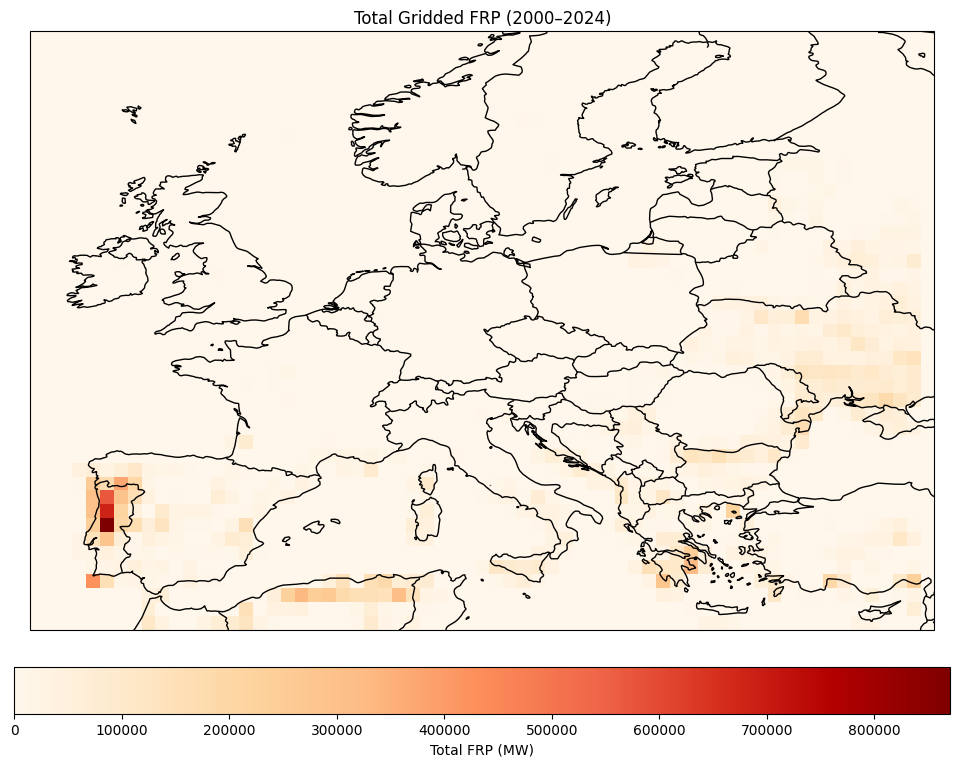

In [5]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the NetCDF dataset
ds = xr.open_dataset(r"D:\IPMA\FRP\FRP_2000_2024_grid.nc")

# Sum over time dimension to get total FRP per grid cell over all days
frp_sum = ds['FRP_sum'].sum(dim='time')

# Plotting
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Plot the summed FRP data
frp_sum.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='OrRd',
    cbar_kwargs={
        'label': 'Total FRP (MW)',
        'orientation': 'horizontal',
        'shrink': 0.8,   # scale the size (optional)
        'pad': 0.05
    }
)

plt.title("Total Gridded FRP (2000–2024)")
plt.tight_layout()
plt.show()


In [ ]:
# 4 days of consecutive fire after outbreak (day 1)

import xarray as xr
import numpy as np
import os

# === Step 1: Load Daily Gridded FRP Data ===
frp_path = r"D:\IPMA\FRP\FRP_2000_2024_grid.nc"
frp_ds = xr.open_dataset(frp_path)
frp = frp_ds["FRP_sum"]  # Dimensions: (time, lat, lon)

# === Step 2: Load Region Masks ===
mask_paths = {
    "Portugal": r"D:\IPMA\Countries\Portugal_mask.nc",
    "Spain":    r"D:\IPMA\Countries\Spain_mask.nc",
    "Greece":   r"D:\IPMA\Countries\Greece_mask.nc",
    "Italy":    r"D:\IPMA\Countries\Italy_mask.nc"
}

# Load masks aligned with FRP grid
masks = {
    region: xr.open_dataset(path)["mask"].sel(
        latitude=frp.coords["latitude"], longitude=frp.coords["longitude"]
    )
    for region, path in mask_paths.items()
}

# === Step 3: Detect Fire Presence (FRP > 0 → fire) ===
fire_binary = (frp > 0).astype(np.uint8)  # 0 or 1
time_len = fire_binary.shape[0]  # Define time_len from the time dimension

# === Step 4: Label Fire Sequences (per pixel, track up to 5 days of burning) ===
fire_np = fire_binary.values  # shape (time, lat, lon)
label_np = np.zeros_like(fire_np, dtype=np.uint8)

for t in range(time_len):
    if t == 0:
        label_np[t] = fire_np[t]
    else:
        prev_label = label_np[t - 1]
        curr_fire = fire_np[t]

        # Fire starts (no fire before)
        start = (curr_fire == 1) & (prev_label == 0)
        label_np[t][start] = 1

        # Fire continues (label < 5 → increment, label == 5 → reset to 1)
        cont = (curr_fire == 1) & (prev_label > 0)
        label_np[t][cont] = (prev_label[cont] % 5) + 1  # Cycles 1–5

# === Step 5: Convert to xarray DataArray ===
fire_label = xr.DataArray(
    label_np,
    coords=frp.coords,
    dims=frp.dims,
    name="fire_label",
    attrs={"description": "0 = no fire, 1 = start, 2–5 = continuation, 6 = 5+ days of fire"}
)

# === Step 6: Apply Region Masks and Save ===
output_dir = r"D:\IPMA\FRP\fire_labels_by_region"
os.makedirs(output_dir, exist_ok=True)

for region, mask in masks.items():
    # Expand 2D mask to 3D (time, lat, lon)
    mask_3d = xr.broadcast(fire_label, mask)[1].astype(bool)

    # Apply mask
    masked_binary = fire_binary.where(mask_3d)
    masked_label = fire_label.where(mask_3d)

    # Save both binary and labeled
    ds = xr.Dataset({
        f"fire_binary_{region}": masked_binary,
        f"fire_label_{region}": masked_label
    })

    ds.to_netcdf(os.path.join(output_dir, f"fire_data_{region}.nc"))

print("✅ Binary and labeled fire data saved per region.")

In [1]:
# 5 days of fire after fire outbreak (day 1)

import xarray as xr
import numpy as np
import os

# === Step 1: Load Daily Gridded FRP Data ===
frp_path = r"D:\IPMA\FRP\FRP_2000_2024_grid.nc"
frp_ds = xr.open_dataset(frp_path)
frp = frp_ds["FRP_sum"]  # Dimensions: (time, lat, lon)

# === Step 2: Load Region Masks ===
mask_paths = {
    "Portugal": r"D:\IPMA\Countries\Portugal_mask.nc",
    "Spain":    r"D:\IPMA\Countries\Spain_mask.nc",
    "Greece":   r"D:\IPMA\Countries\Greece_mask.nc",
    "Italy":    r"D:\IPMA\Countries\Italy_mask.nc"
}

# Load masks aligned with FRP grid
masks = {
    region: xr.open_dataset(path)["mask"].sel(
        latitude=frp.coords["latitude"], longitude=frp.coords["longitude"]
    )
    for region, path in mask_paths.items()
}

# === Step 3: Detect Fire Presence (FRP > 0 → fire) ===
fire_binary = (frp > 0).astype(np.uint8)  # 0 or 1
time_len = fire_binary.shape[0]  # Define time_len from the time dimension

# === Step 4: Label Fire Sequences (per pixel, track up to 5 days of burning) ===
fire_np = fire_binary.values  # shape (time, lat, lon)
label_np = np.zeros_like(fire_np, dtype=np.uint8)

for t in range(time_len):
    if t == 0:
        label_np[t] = fire_np[t]
    else:
        prev_label = label_np[t - 1]
        curr_fire = fire_np[t]

        # Fire starts (no fire before)
        start = (curr_fire == 1) & (prev_label == 0)
        label_np[t][start] = 1

        # Fire continues (label < 5 → increment, label == 5 → reset to 1)
        cont = (curr_fire == 1) & (prev_label > 0)
        label_np[t][cont] = (prev_label[cont] % 6) + 1  # Cycles 1–5

# === Step 5: Convert to xarray DataArray ===
fire_label = xr.DataArray(
    label_np,
    coords=frp.coords,
    dims=frp.dims,
    name="fire_label",
    attrs={"description": "0 = no fire, 1 = start, 2–5 = continuation, 6 = 5+ days of fire"}
)

# === Step 6: Apply Region Masks and Save ===
output_dir = r"D:\IPMA\FRP\fire_labels_by_region"
os.makedirs(output_dir, exist_ok=True)

for region, mask in masks.items():
    # Expand 2D mask to 3D (time, lat, lon)
    mask_3d = xr.broadcast(fire_label, mask)[1].astype(bool)

    # Apply mask
    masked_binary = fire_binary.where(mask_3d)
    masked_label = fire_label.where(mask_3d)

    # Save both binary and labeled
    ds = xr.Dataset({
        f"fire_binary_{region}": masked_binary,
        f"fire_label_{region}": masked_label
    })

    ds.to_netcdf(os.path.join(output_dir, f"fire_data_{region}.nc"))

print("✅ Binary and labeled fire data saved per region.")

✅ Binary and labeled fire data saved per region.


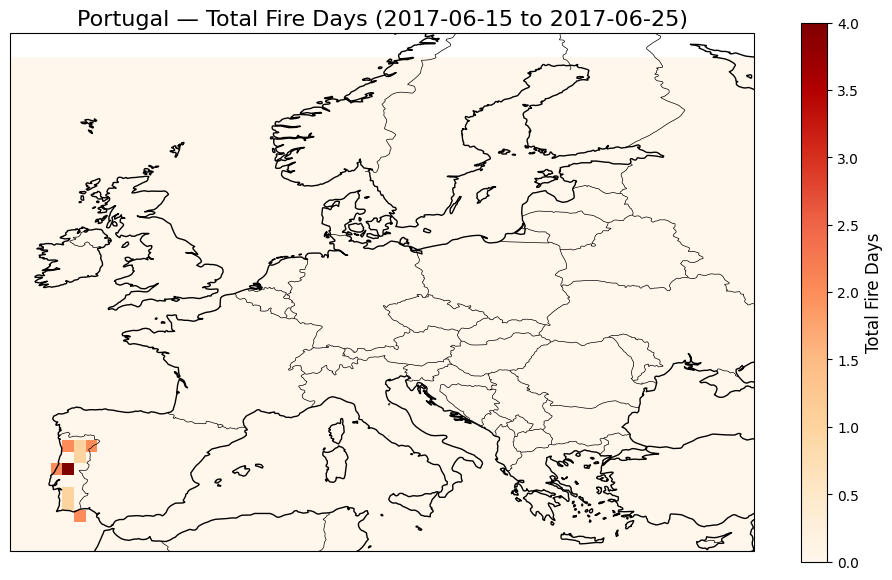

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# === Step 1: Load region output ===
region = "Portugal"
path = f"D:/IPMA/FRP/fire_labels_by_region/fire_data_{region}.nc"
ds = xr.open_dataset(path)
fire_label = ds[f"fire_label_{region}"]

# === Step 2: Select time range covering Pedrógão Grande fire ===
start_date = "2017-06-15"
end_date = "2017-06-25"
fire_label_sel = fire_label.sel(time=slice(start_date, end_date))

# === Step 3: Count total fire days (labels 1–6) per pixel ===
total_fire_days = (fire_label_sel >= 1).sum(dim="time")  # Total fire days per pixel

# === Step 4: Plot the map ===
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title(f"{region} — Total Fire Days ({start_date} to {end_date})", fontsize=16)

im = ax.pcolormesh(
    total_fire_days.longitude, total_fire_days.latitude, total_fire_days,
    cmap="OrRd", shading="auto", transform=ccrs.PlateCarree()
)

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_extent([
    total_fire_days.longitude.min().item(), total_fire_days.longitude.max().item(),
    total_fire_days.latitude.min().item(), total_fire_days.latitude.max().item()
])

cbar = plt.colorbar(im, ax=ax, shrink=0.7)
cbar.set_label("Total Fire Days", fontsize=12)

plt.show()
